In [1]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import models.Neural_ODEs_v2 as nodes
import models.DynamicalSystems as ds

In [2]:
# Models

In [3]:
lorenz = ds.Lorenz(sigma = 10.0, rho = 28.0, beta = 8.0/3.0)
hopf = ds.Hopf(rho=1.0, alpha = -1.0, omega=0.0, beta=-0.0)
sn = ds.saddlenode(a = -0.5)

In [4]:
import lyapynov as lya 

In [5]:
lorenz.f = lorenz.na_f

In [6]:
lorenz.drive_rate = 0.01

In [21]:
lorenz.solve(x0 = torch.tensor([[1.0, 1.0, 1.0, 10]]), t_span=(0, 1600), dt=0.01)

tensor([[[ 1.0000,  1.0000,  1.0000, 10.0000]],

        [[ 1.0039,  1.0798,  0.9840, 10.0001]],

        [[ 1.0149,  1.1596,  0.9692, 10.0002]],

        ...,

        [[ 8.1531,  8.1533, 24.9244, 25.9247]],

        [[ 8.1532,  8.1533, 24.9245, 25.9248]],

        [[ 8.1532,  8.1533, 24.9246, 25.9249]]])

In [7]:
lorenz.f(0, torch.tensor([1.0, 1.0, 1.0, 10.0]))

tensor([[ 0.0000,  8.0000, -1.6667,  0.0100]])

In [8]:
lorenz.f_numpy(0, np.array([1.0, 1.0, 1.0, 10.0]))

array([ 0.       ,  8.       , -1.6666667,  0.01     ], dtype=float32)

In [16]:
list_ma_lorenz = []
for i in tqdm(range(0, 20)):
    lorenz_lya = lya.ContinuousDS(x0 = np.array([1.0, 1.0, 1.0, 10.0]), t0 = 0, f=lambda x, t: lorenz.f_numpy(t, x), jac=lambda x, t: lorenz.jacobian_numpy(t, x), dt=0.01)
    out = lya.LCE(system = lorenz_lya, p=1, n_forward=10_000*i, n_compute=10_000, keep=False)
    list_ma_lorenz.append(out)



100%|██████████| 20/20 [02:58<00:00,  8.91s/it]


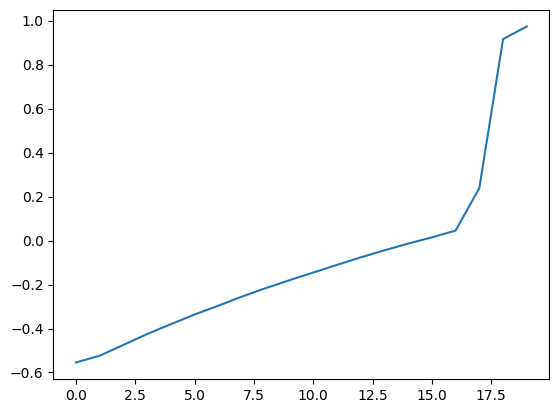

In [17]:
plt.plot(list_ma_lorenz)

# Trainined Model

In [22]:
model_lorenz = torch.load('models/lorenz_driven_neural_ODE_m1.pt', weights_only=False)

In [23]:
class Neural_Lorenz(ds.DynamicalSystem_torch):
    def __init__(self, model):
        super().__init__(dim=4)
        self.model = model 

    def f(self, t, x):
        t, x = self.f_tests(t, x)
        return self.model(t, x)

In [29]:
model_lorenz.drdt = 0.01
node_lorenz = Neural_Lorenz(model=model_lorenz)

In [31]:
list_ma_lorenz_node = []
for i in tqdm(range(0, 20)):
    lorenz_lya_node = lya.ContinuousDS(x0 = np.array([1.0, 1.0, 1.0, 10.0]), t0 = 0, f=lambda x, t: node_lorenz.f_numpy(t, x), jac=lambda x, t: node_lorenz.jacobian_numpy(t, x), dt=0.01)
    out = lya.LCE(system = lorenz_lya_node, p=1, n_forward=10_000*i, n_compute=10_000, keep=False)
    list_ma_lorenz_node.append(out)

100%|██████████| 20/20 [04:49<00:00, 14.47s/it]


In [63]:
rho_func = lambda t: 11.0 + 0.01*t
rho_pts_lorenz = rho_func(t=np.arange(0, 2_000, 100))

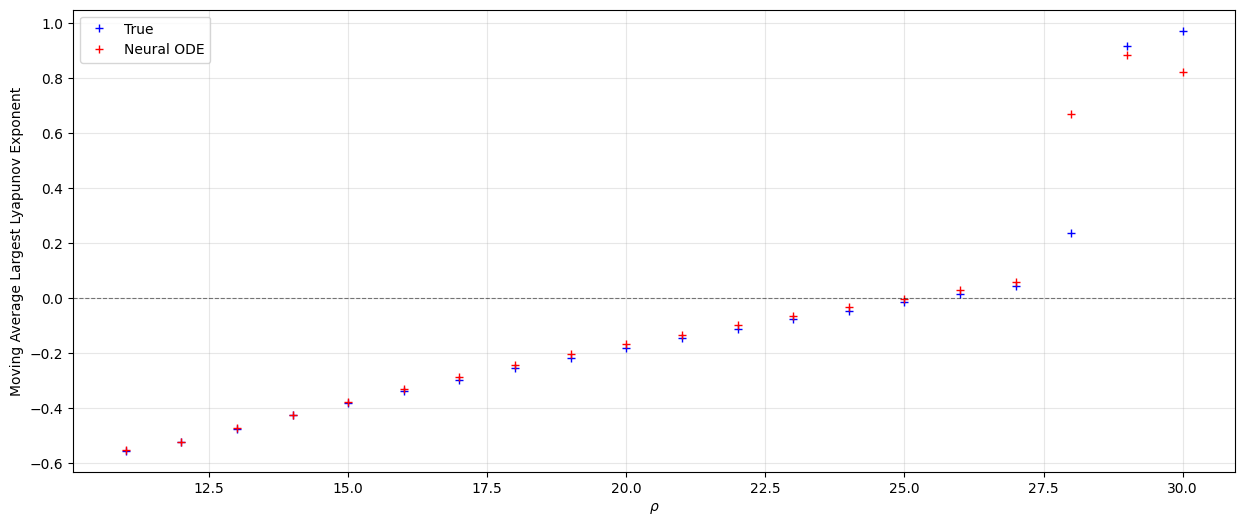

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharey=True)

# Lorenz plot
axes.plot(rho_pts_lorenz, list_ma_lorenz, color='b', linestyle='', marker='+', label='True')
axes.plot(rho_pts_lorenz, list_ma_lorenz_node, color='r', linestyle='', marker='+', label='Neural ODE')
axes.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)

axes.set_ylabel('Moving Average Largest Lyapunov Exponent')
axes.set_xlabel(r'$\rho$')
axes.grid(True, alpha=0.3)
axes.legend()


In [ ]:
# Changing Interval

In [55]:
list_ma_lorenz_node2 = []
for i in tqdm(range(0, 40)):
    lorenz_lya_node = lya.ContinuousDS(x0 = np.array([1.0, 1.0, 1.0, 10.0]), t0 = 0, f=lambda x, t: node_lorenz.f_numpy(t, x), jac=lambda x, t: node_lorenz.jacobian_numpy(t, x), dt=0.01)
    out = lya.LCE(system = lorenz_lya_node, p=1, n_forward=5_000*i, n_compute=5_000, keep=False)
    list_ma_lorenz_node2.append(out)

100%|██████████| 40/40 [08:45<00:00, 13.14s/it]


In [61]:
steps = 2_000
num_interval = int(200_000 / steps)

list_ma_lorenz_node3 = []
for i in tqdm(range(0, num_interval)):
    lorenz_lya_node = lya.ContinuousDS(x0 = np.array([1.0, 1.0, 1.0, 10.0]), t0 = 0, f=lambda x, t: node_lorenz.f_numpy(t, x), jac=lambda x, t: node_lorenz.jacobian_numpy(t, x), dt=0.01)
    out = lya.LCE(system = lorenz_lya_node, p=1, n_forward=steps*i, n_compute=steps, keep=False)
    list_ma_lorenz_node3.append(out)

100%|██████████| 100/100 [20:40<00:00, 12.40s/it]


In [82]:
interval_size = 20_000
steps = 10_000
num_interval = int(200_000 / steps)

list_ma_lorenz_node4 = []
for i in tqdm(range(0, num_interval)):
    lorenz_lya_node = lya.ContinuousDS(x0 = np.array([1.0, 1.0, 1.0, 10.0]), t0 = 0, f=lambda x, t: node_lorenz.f_numpy(t, x), jac=lambda x, t: node_lorenz.jacobian_numpy(t, x), dt=0.01)
    out = lya.LCE(system = lorenz_lya_node, p=1, n_forward=steps*i, n_compute=interval_size, keep=False)
    list_ma_lorenz_node4.append(out)

100%|██████████| 20/20 [05:45<00:00, 17.26s/it]


In [69]:
rho_func = lambda t: 11.0 + 0.01*t
rho_pts_lorenz1 = rho_func(t=np.arange(0, 2_000, 50))

In [83]:
rho_func = lambda t: 11.0 + 0.01*t
rho_pts_lorenz2 = rho_func(t=np.arange(0, 2_000, 20))
rho_pts_lorenz3 = rho_func(t=np.arange(0, 2_000, 100))

In [84]:
rho_pts_lorenz1.shape

(40,)

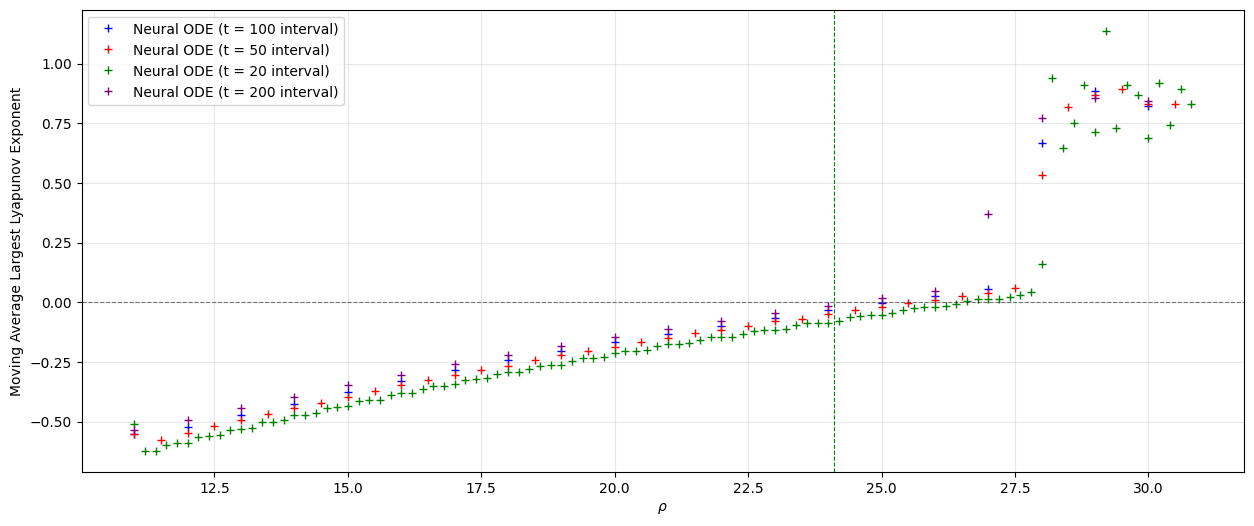

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharey=True)

# Lorenz plot
axes.plot(rho_pts_lorenz, list_ma_lorenz_node, color='b', linestyle='', marker='+', label='Neural ODE (t = 100 interval)')
axes.plot(rho_pts_lorenz1, list_ma_lorenz_node2, color='r', linestyle='', marker='+', label='Neural ODE (t = 50 interval)')
axes.plot(rho_pts_lorenz2, list_ma_lorenz_node3, color='g', linestyle='', marker='+', label='Neural ODE (t = 20 interval)')
axes.plot(rho_pts_lorenz3, list_ma_lorenz_node4, color='purple', linestyle='', marker='+', label='Neural ODE (t = 200 interval)')
#axes.plot(rho_pts_lorenz, list_ma_lorenz_node, color='r', linestyle='', marker='+', label='Neural ODE')
axes.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes.axvline(x=24.1, color='g', linestyle='--', linewidth=0.8, alpha=1)
axes.set_ylabel('Moving Average Largest Lyapunov Exponent')
axes.set_xlabel(r'$\rho$')
axes.grid(True, alpha=0.3)
axes.legend()


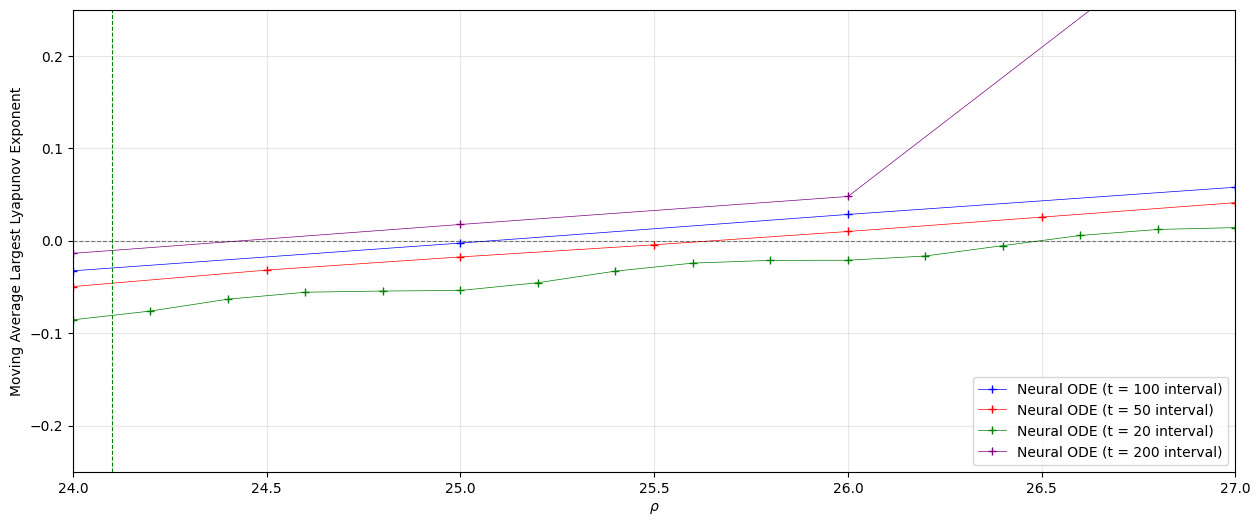

In [90]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharey=True)

# Lorenz plot
axes.plot(rho_pts_lorenz, list_ma_lorenz_node, color='b', linestyle='-', marker='+', linewidth=0.5, label='Neural ODE (t = 100 interval)')
axes.plot(rho_pts_lorenz1, list_ma_lorenz_node2, color='r', linestyle='-', marker='+', linewidth=0.5, label='Neural ODE (t = 50 interval)')
axes.plot(rho_pts_lorenz2, list_ma_lorenz_node3, color='g', linestyle='-', marker='+', linewidth=0.5, label='Neural ODE (t = 20 interval)')
axes.plot(rho_pts_lorenz3, list_ma_lorenz_node4, color='purple', linestyle='-', marker='+', linewidth=0.5, label='Neural ODE (t = 200 interval)')
#axes.plot(rho_pts_lorenz, list_ma_lorenz_node, color='r', linestyle='', marker='+', label='Neural ODE')
axes.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes.axvline(x=24.1, color='g', linestyle='--', linewidth=0.8, alpha=1)
axes.set_xlim(24, 27)
axes.set_ylim(-0.25, 0.25)
axes.set_ylabel('Moving Average Largest Lyapunov Exponent')
axes.set_xlabel(r'$\rho$')
axes.grid(True, alpha=0.3)
axes.legend()

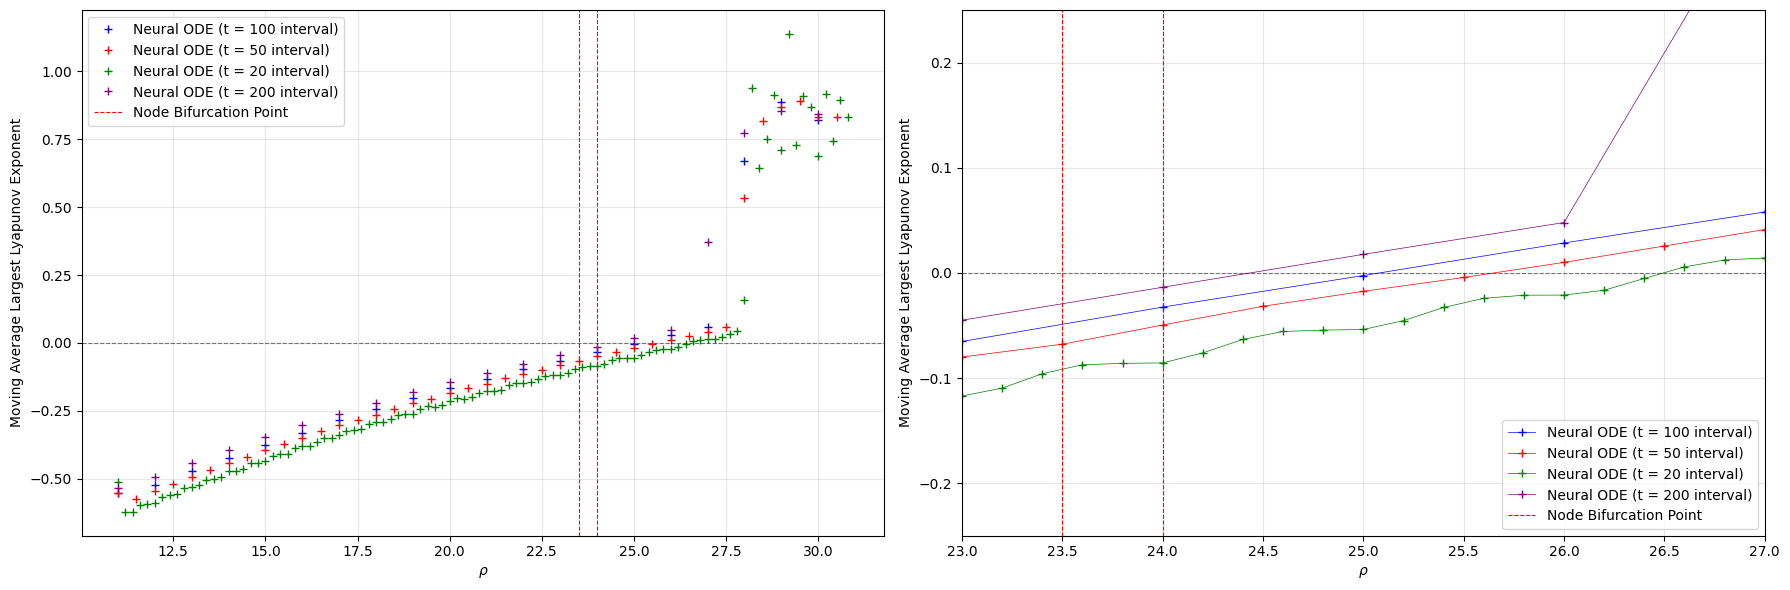

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Left plot - Full view (from cell 85)
axes[0].plot(rho_pts_lorenz, list_ma_lorenz_node, color='b', linestyle='', marker='+', label='Neural ODE (t = 100 interval)')
axes[0].plot(rho_pts_lorenz1, list_ma_lorenz_node2, color='r', linestyle='', marker='+', label='Neural ODE (t = 50 interval)')
axes[0].plot(rho_pts_lorenz2, list_ma_lorenz_node3, color='g', linestyle='', marker='+', label='Neural ODE (t = 20 interval)')
axes[0].plot(rho_pts_lorenz3, list_ma_lorenz_node4, color='purple', linestyle='', marker='+', label='Neural ODE (t = 200 interval)')
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0].axvline(x=23.5, color='r', linestyle='--', linewidth=0.8, alpha=1)
axes[0].axvline(x=24, color='r', linestyle='--', linewidth=0.8, alpha=1, label='Node Bifurcation Point')
axes[0].set_ylabel('Moving Average Largest Lyapunov Exponent')
axes[0].set_xlabel(r'$\rho$')
#axes[0].set_title('Full View')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Right plot - Zoomed view (from cell 90)
axes[1].plot(rho_pts_lorenz, list_ma_lorenz_node, color='b', linestyle='-', marker='+', linewidth=0.5, label='Neural ODE (t = 100 interval)')
axes[1].plot(rho_pts_lorenz1, list_ma_lorenz_node2, color='r', linestyle='-', marker='+', linewidth=0.5, label='Neural ODE (t = 50 interval)')
axes[1].plot(rho_pts_lorenz2, list_ma_lorenz_node3, color='g', linestyle='-', marker='+', linewidth=0.5, label='Neural ODE (t = 20 interval)')
axes[1].plot(rho_pts_lorenz3, list_ma_lorenz_node4, color='purple', linestyle='-', marker='+', linewidth=0.5, label='Neural ODE (t = 200 interval)')
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1].axvline(x=23.5, color='r', linestyle='--', linewidth=0.8, alpha=1)
axes[1].axvline(x=24, color='r', linestyle='--', linewidth=0.8, alpha=1, label='Node Bifurcation Point')
axes[1].set_xlim(23, 27)
axes[1].set_ylim(-0.25, 0.25)
axes[1].set_ylabel('Moving Average Largest Lyapunov Exponent')
axes[1].set_xlabel(r'$\rho$')
#axes[1].set_title('Zoomed View (\u03c1 = 24-27)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()

In [56]:
def largest_lyapunov_exponent(model, x0, dt, t_span):
    n_compute = int((t_span[1] - t_span[0]) / dt)
    n_transient = int(t_span[0] / dt)
    lya_system = lya.ContinuousDS(x0 = x0, t0 = 0, f=lambda x, t: model.f_numpy(t, x), jac=lambda x, t: model.jacobian_numpy(t, x), dt=dt)
    out = lya.LCE(system = lya_system, p=1, n_forward=n_compute, n_compute=n_compute, keep=False)
    return out

In [ ]:
# Dynamical Systems Analysis

In [109]:
class DynamicalSystems_analysis: 
    '''
    Class to analyze the dynamical system, including computing Lyapunov exponents, bifurcation diagrams, and other relevant metrics.

    Attributes:
    - model: The dynamical system model to be analyzed. Should be an instance of DynamicalSystem_torch. 

    Methods:
    - compute_lyapunov_exponent(x0, dt, t_span): Computes the largest Lyapunov exponent for the given initial condition, time step, and time span.

    '''
    def __init__(self, model: ds.DynamicalSystem_torch):
        self.model = model 

    def lyapunov_exponents(self, x0, dt, t_span: tuple, num_exponents=1, keep_data=False):
        '''
        Computes the largest Lyapunov exponent for the given model, initial condition, time step, and time span.

        Uses methods from the lyapynov package to compute the Lyapunov exponent.

        Currently requires numpy array - will need to modify to work with torch tensors in future. 

        Parameters:
        - x0: The initial condition for the system. Should be a numpy array.
        - dt: The time step for the computation.
        - t_span: A tuple (t_start, t_end) specifying the time span for the computation. Computation will start at t = 0 and discard items before t_start as transient, and compute the Lyapunov exponent over the interval [t_start, t_end].

        - num_exponents: The number of Lyapunov exponents to compute. Default is 1 (largest Lyapunov exponent).
        - keep_data: Whether to keep the full data of the Lyapunov exponent computation. Default is False (only keep the final exponent values).
        '''
        if not isinstance(x0, np.ndarray):
            raise ValueError("x0 should be a numpy array.")
        
        if not isinstance(dt, (int, float)):
            raise ValueError("dt should be a numeric value.")
        
        if num_exponents < 1 or num_exponents > self.model.system_dim:
            raise ValueError("num_exponents should be at least 1 and no greater than system dimension ({}).".format(self.model.system_dim))

        n_compute = int((t_span[1] - t_span[0]) / dt)
        n_transient = int(t_span[0] / dt)
        lya_system = lya.ContinuousDS(x0 = x0, t0 = 0, f=lambda x, t: self.model.f_numpy(t, x), jac=lambda x, t: self.model.jacobian_numpy(t, x), dt=dt)
        out = lya.LCE(system = lya_system, p=num_exponents, n_forward=n_transient, n_compute=n_compute, keep=keep_data)
        return out


In [110]:
class Neural_DynamicalSystem(ds.DynamicalSystem_torch):
    def __init__(self, model):
        super().__init__(dim=model.input_dim)
        self.model = model 

    def f(self, t, x):
        t, x = self.f_tests(t, x)
        return self.model(t, x)
    


In [123]:
list = []
for i in tqdm(range(0, 4)):
    list.append((10+10*i, 20+10*i))

100%|██████████| 4/4 [00:00<00:00, 111848.11it/s]


In [134]:
# Use multiprocess instead of multiprocessing for notebook compatibility
# Install with: pip install multiprocess
import multiprocessing as mp

In [128]:
def test_func(x):
    return x

In [129]:
def test_func2(x):
    return lorenz_analysis.lyapunov_exponents(x0=np.array([1.0, 1.0, 1.0, 10.0]), dt=0.01, t_span=x, num_exponents=1, keep_data=False)

In [133]:
with mp.Pool(processes=4) as pool:
    results = pool.map(test_func2, list)

Process SpawnPoolWorker-17:
Process SpawnPoolWorker-20:
Process SpawnPoolWorker-18:
Process SpawnPoolWorker-19:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/L

KeyboardInterrupt: 

In [113]:
lorenz_analysis = DynamicalSystems_analysis(model=node_lorenz)

lorenz_analysis.lyapunov_exponents(x0=np.array([1.0, 1.0, 1.0, 10.0]), dt=0.01, t_span=(100, 200), num_exponents=1, keep_data=False)

array([-0.52406097])

In [ ]:
def largest_lyapunov_exponent(model, x0, dt, t_span):
    n_compute = int((t_span[1] - t_span[0]) / dt)
    n_transient = int(t_span[0] / dt)
    lya_system = lya.ContinuousDS(x0 = x0, t0 = 0, f=lambda x, t: model.f_numpy(t, x), jac=lambda x, t: model.jacobian_numpy(t, x), dt=dt)
    out = lya.LCE(system = lya_system, p=1, n_forward=n_compute, n_compute=n_compute, keep=False)
    return out